## 7.2 图像卷积
上节课我们简单介绍了卷积和卷积层的基本知识。考虑到图像卷积是理解卷积神经网络的关键，本节咱们更详细的阐述相关细节内容，尤其是实际应用和代码实现，帮助你加深理解。先来看看卷积和互运算两个概念。

### 7.2.1 卷积运算 vs 互相关运算

在图像卷积中，这两个数学概念经常容易混淆。互相关运算（cross-correlation）的数学定义如下：

$$(I * K)(x,y)=\sum_{s=-\infty}^{\infty}\sum_{t=-\infty}^{\infty}I(x+s,y+t) \cdot K(s,t)$$

其中，$I$ 是输入图像，$K$ 是卷积核，$*$ 是互相关运算的符号，$(x,y)$ 是输出图像中的像素坐标。你可能发现了，这个公式怎么特别像上一小节图像卷积的公式呢？是的，这也是让很多同学混乱的地方，它们的确就是一回事。稍等咱们就解释清楚。再来看看真正的卷积运算（convolution）数学公式：

$$(I * K)(x,y)=\sum_{s=-\infty}^{\infty}\sum_{t=-\infty}^{\infty}I(s,t) \cdot K(x-s,y-t)$$

其中，$I$ 是输入图像，$K$ 是卷积核，$*$ 是卷积运算的符号，$(x,y)$ 是输出图像中的像素坐标。

二者是不是长的很像，只差了一个正负号，卷积和互相关相比加号变成了减号。严格说在数学上它们是不同的运算，但是在图像处理领域，两者差别就没那么明显了，或者说反而产生了混用现象。我们用一个例子来加以说明。先看互相关运算，下图左边为原始图像，它和一个卷积核做互相关运算后得到右边的输出图像。
<img src="../images/7-2-1.png" width="70%"></img>
卷积核在左边图像上滑动，同时做互相关运算，也就是对应元素相乘在相加。由于原图像多数元素都为0，只在输入图像中心为1，因此最后输出了右边图像。结果显示相当于把卷积核进行了180度翻转。

再来看卷积运算，公式中它和互相关相比改变了符号，体现在图像上就是先把卷积核进行了180度翻转，或者说就是先左右翻转，然后上下翻转，然后再进行互相关运算。如下图所示：
<img src="../images/7-2-2.png" width="70%"></img>

由于卷积运算相当于翻转了两次，因此最后输出图像中还是123456789这样的顺序，而互相关运算只翻转了一次，最终结果变成了987654321这样的形式。

虽然两种运算看似不同，但由于卷积核是自己定的，本身没有顺序上的限制，所以完全可以用翻转过的卷积核，这样以来二者就没啥区别了。也正是因为这个原因，大部分深度学习框架在代码实现的时候偷了懒，干脆用了互相关运算替代了卷积。因此严格意义上说，卷积层用的是互相关运算，但依然被叫成了卷积。这就像是双胞胎，明明是老大干活，却总被叫成老二一样，不过对外人而言区别不大。本书后续课程，将遵循惯例，不再对二者做明确区分。

In [7]:
import torch
import torch.nn.functional as F

# 定义输入图像和卷积核
image = torch.zeros(7, 7, dtype=torch.float32)

# 将中心位置设置为 1
image[3][3] = 1.0

kernel = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]],dtype=torch.float32)

# 计算卷积
result = F.conv2d(image.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding = 1)
print(result)

tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 8., 7., 0., 0.],
          [0., 0., 6., 5., 4., 0., 0.],
          [0., 0., 3., 2., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])


结果和前面图示中完全一致，注意在计算卷积时我们填充了一圈0，以便保证输出图像大小与输入一致。

### 7.2.2 卷积层

卷积层对输入和卷积核权重进行互相关运算，同时加入偏置。因此，卷积层训练的目标是找到卷积核权重和偏置这些参数。我们下面来看下如何用pytorch实现一个二维图像卷积运算的训练过程。

In [4]:
import torch
import torch.nn as nn

# 定义数据
input_tensor = torch.randn(1, 1, 28, 28)
target_tensor = torch.randn(1, 1, 28, 28)

# 定义卷积层
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)

# 计算卷积
output_tensor = conv(input_tensor)
print(output_tensor.shape)  # 输出: torch.Size([1, 1, 28, 28])

# 定义损失函数和优化器
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(conv.parameters(), lr=0.001)

# 定义训练循环
for epoch in range(100):
    # 计算损失
    output_tensor = conv(input_tensor)
    loss = loss_fn(output_tensor, target_tensor)

    # 清空梯度
    optimizer.zero_grad()

    # 计算梯度并更新权重
    loss.backward()
    optimizer.step()
    
print(conv.state_dict())

torch.Size([1, 1, 28, 28])
OrderedDict([('weight', tensor([[[[-0.0327, -0.1699, -0.0087],
          [-0.0618,  0.1318,  0.1570],
          [ 0.1586, -0.0503, -0.2356]]]])), ('bias', tensor([-0.0731]))])


在这个例子中，我们定义了输入输出张量，并使用 nn.Conv2d 类定义了一个卷积层。然后我们使用这个卷积层来计算卷积，输出的张量的形状为 (1, 1, 28, 28)。接下来，我们定义了一个损失函数和优化器，并在循环中不断地计算损失、清空梯度、计算梯度和更新权重。输出结果是一个字典，其中包含了卷积层的权重和偏置项。

### 7.2.3 卷积层特征

卷积层的特征映射（feature map）是指卷积层对输入数据进行卷积后得到的输出张量。特征映射中的每个元素都是输入张量中相应区域的卷积和，其中区域的大小和形状由卷积层的内核大小决定。

例如，假设输入张量的大小为 $H \times W$，内核大小为 $k \times k$，那么卷积层的输出张量大小就为 $\frac{H - k + 2p}{s} + 1 \times \frac{W - k + 2p}{s} + 1$，其中 $p$ 是 padding 的大小，$s$ 是 stride 的大小。

卷积层的感受野（receptive field）是指输入张量中卷积层特征映射中的每个元素所能“感受”到的区域。例如，假设输入张量的大小为 $H \times W$，内核大小为 $k \times k$，那么卷积层的感受野大小就为 $k \times k$。

举个例子，假设输入张量是一张 $5 \times 5$ 的图像，卷积层使用 $3 \times 3$ 的内核，stride 为 $1$，padding 为 $0$，那么卷积层的输出张量大小为 $3 \times 3$，感受野大小为 $3 \times 3$。


### 7.2.4 卷积层应用示例

如何用卷积层来实现滤波器的效果呢？我们来演示一个具体的示例。创建一个 8x8 的 tensor，得到黑白相间的图像。然后创建卷积核进行卷积运算，从而实现边缘检测效果。

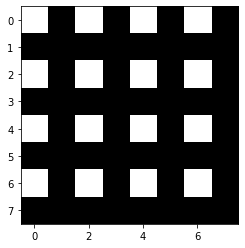

tensor([[[[-1.,  1., -1.,  1., -1.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [-1.,  1., -1.,  1., -1.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [-1.,  1., -1.,  1., -1.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [-1.,  1., -1.,  1., -1.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]])


In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 创建 8x8 张量
image = torch.zeros(8, 8)
image[::2, ::2] = 1
# image[1::2, 1::2] = 0

# 将 image 张量转换为 numpy 数组
image_np = image.numpy()

# 使用 matplotlib 的 imshow 函数将图像显示出来
plt.imshow(image_np, cmap='gray')
plt.show()

# 创建卷积核
kernel = torch.tensor([[-1.0, 1.0]])

# 使用卷积核对 image 进行卷积
output = F.conv2d(image.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0))

print(output)

输出结果是个8x7张量，其中每个位置的值是1或-1的地方显示了检测到的边缘，可以看到全黑色的行中没有边缘，因此所有元素都为0。

### 7.2.5 卷积核可以学习获得吗？

在前面的例子当中，卷积核（也称内核）都是手工指定的。你有没有想过，它可以通过数据训练得到吗？答案是可以的。我们来看一个例子。首先，需要定义训练数据和标签。例如，假设你有一个 5x5 的图像和一个 3x3 的标签，则可以使用如下的代码将它们转换为 PyTorch 张量

In [16]:
import torch

# 创建训练数据和标签
data = torch.zeros(1, 1, 5, 5)
label = torch.zeros(1, 1, 3, 3)

# 将训练数据和标签转换为 PyTorch 张量
data = data.float()
label = label.float()

import torch.nn as nn

# 创建卷积层，输入通道数为 1，输出通道数为 1
conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)

# 定义损失函数和优化器
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(conv.parameters(), lr=0.001)

# 训练模型
for i in range(1000):
    # 计算预测值
    output = conv(data)

    # 计算损失
    loss = loss_fn(output, label)

    # 清空梯度
    optimizer.zero_grad()

    # 反向传播
    loss.backward()

    # 优化模型参数
    optimizer.step()

# 访问卷积层的卷积核
conv_kernel = conv.weight.data
print(conv_kernel)

# 访问卷积层的偏置项
conv_bias = conv.bias.data
print(conv_bias)


tensor([[[[-0.1686,  0.0775,  0.1561],
          [-0.0111,  0.1880,  0.2825],
          [-0.1479,  0.1595,  0.0020]]]])
tensor([0.0165])


[Next 7-3 常用操作](./7-3%20常用操作.ipynb)